## Import package

In [1]:
from __future__ import division

import warnings
warnings.filterwarnings("ignore")
    
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import ADASYN, SMOTE

## Load dataset: Train

In [2]:
train = pd.read_csv("../../../../../data/train/train.csv")
test = pd.read_csv("../../../../../data/test/test.csv")

In [3]:
print(train.shape)
print(test.shape)

(9557, 143)
(23856, 142)


In [4]:
train.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [5]:
test.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [6]:
f = open("../../../resources/continuousFeatures", "r")
continuous_columns = f.read().split(",")
f.close()

f = open("../../../resources/categoricalFeatures", "r")
categorical_columns = f.read().split(",")
f.close()

f = open("../../../resources/yesNoFeaturesNames", "r")
yes_no_columns = f.read().split(",")
f.close()

print("Number of numerical columns: {0}".format(len(continuous_columns)))
print("Number of categorical columns: {0}".format(len(categorical_columns)))
print("Number of yes/no columns: {0}".format(len(yes_no_columns)))

Number of numerical columns: 38
Number of categorical columns: 102
Number of yes/no columns: 3


In [7]:
category, category_ount = np.unique(train["Target"], return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_ount)))

(Category, Count): [(1, 755), (2, 1597), (3, 1209), (4, 5996)]


## Fil Yes/No values

In [8]:
# yes=1 and no=0
def fill_yes_no(value):
    if value == "yes":
        return 1
    elif value == "no":
        return 0
    else:
        return value

In [12]:
for column in yes_no_columns:
    train["new_{0}".format(column)] = train.apply(lambda row: fill_yes_no(row[column]), axis=1)
    test["new_{0}".format(column)] = test.apply(lambda row: fill_yes_no(row[column]), axis=1)

train = train.drop(yes_no_columns, axis=1)
test = test.drop(yes_no_columns, axis=1)

columns={"new_{0}".format(column): column for column in yes_no_columns}
train = train.rename(index=str, columns=columns)
test = test.rename(index=str, columns=columns)

## Fill Nan values

In [13]:
null_columns = train.isnull().any()

In [14]:
null_columns = train.columns[train.isnull().any()].tolist() ## continuous variables
null_columns

['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']

In [15]:
train[["Target","v2a1", 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']].head()

,Target,v2a1,v18q1,rez_esc,meaneduc,SQBmeaned
0,4,190000.0,NaN,NaN,10.0,100.0
1,4,135000.0,1.0,NaN,12.0,144.0
2,4,NaN,NaN,NaN,11.0,121.0
3,4,180000.0,1.0,1.0,11.0,121.0
4,4,180000.0,1.0,NaN,11.0,121.0


In [16]:
label_mean = train[null_columns].mean()
# label_mean.to_dict()

In [17]:
label_mean

v2a1         165231.606971
v18q1             1.404063
rez_esc           0.459791
meaneduc          9.231523
SQBmeaned       102.588867
dtype: float64

In [19]:
for column in null_columns:
    train["new_{0}".format(column)] = train.apply(
    lambda row: label_mean[column] if np.isnan(row[column]) else row[column],
    axis=1)
    
    test["new_{0}".format(column)] = test.apply(
    lambda row: label_mean[column] if np.isnan(row[column]) else row[column],
    axis=1)    

train = train.drop(null_columns, axis=1)
test = test.drop(null_columns, axis=1)
train = train.rename(index=str, columns={"new_{0}".format(column): column for column in null_columns})
test = test.rename(index=str, columns={"new_{0}".format(column): column for column in null_columns})

## Standard scaled

In [20]:
from sklearn.preprocessing import StandardScaler
estimator = StandardScaler(copy=True, with_mean=True, with_std=True)
model = estimator.fit(train[continuous_columns])
X_scaled = model.transform(train[continuous_columns])

x_test_scaled = model.transform(test[continuous_columns])

## Train - Validation split

In [21]:
X_train, X_validation, y_train, y_validation = train_test_split(X_scaled, train["Target"], test_size=0.2, stratify=train["Target"])

In [22]:
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

((7645, 38), (7645,))
((1912, 38), (1912,))


In [23]:
category, category_count = np.unique(y_train, return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_count)))
      
category, category_count = np.unique(y_validation, return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_count)))     

(Category, Count): [(1, 604), (2, 1278), (3, 967), (4, 4796)]
(Category, Count): [(1, 151), (2, 319), (3, 242), (4, 1200)]


## Logistic Regression Classifier

In [24]:
def logistic_regression_prediction(reg_param, X_train, y_train, X_test):
    estimator = LogisticRegression(penalty="l2", C=reg_param)
    model = estimator.fit(X_train, y_train)
    return model.predict(X_train), model.predict(X_test)

In [25]:
def all_score(y_true, y_prediction):
    accuracy = accuracy_score(y_true, y_prediction)
    precision = precision_score(y_true, y_prediction, average="macro")
    recall = recall_score(y_true, y_prediction, average="macro")
    f1 = f1_score(y_true, y_prediction, average="macro")
    return accuracy, precision, recall, f1

In [26]:
def print_score(accuracy, precision, recall, f1):
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)

## Classification: Logistic Regression Classifier

In [27]:
prediction_train, prediction_validation = logistic_regression_prediction(1e7, X_train, y_train, X_validation)

In [28]:
accuracy, precision, recall, f1 = all_score(y_validation, prediction_validation)
print_score(accuracy, precision, recall, f1)

('Accuracy:', 0.6621338912133892)
('Precision:', 0.5079641433336411)
('Recall:', 0.3551158673030624)
('F1:', 0.3529199811302385)


In [29]:
confusion_mc = confusion_matrix(y_validation, prediction_validation)
print confusion_mc

[[  17   56    0   78]
 [  12  106    5  196]
 [   1   51    7  183]
 [   5   55    4 1136]]


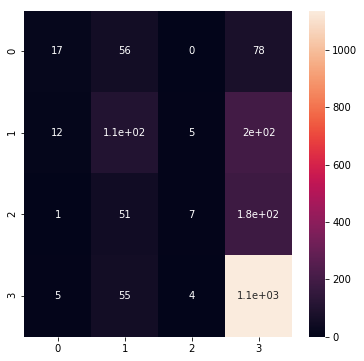

In [30]:
# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

In [31]:
unique_elements, counts_elements = np.unique(prediction_validation, return_counts=True)
print(unique_elements)
print(counts_elements)

[1 2 3 4]
[  35  268   16 1593]


In [32]:
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(prediction_validation, y_validation, target_names=target_names))

             precision    recall  f1-score   support

    class 1       0.11      0.49      0.18        35
    class 2       0.33      0.40      0.36       268
    class 3       0.03      0.44      0.05        16
    class 4       0.95      0.71      0.81      1593

avg / total       0.84      0.66      0.73      1912



## Balanced datasets - ADASYN

In [33]:
ada = ADASYN()
X_ada, y_ada = ada.fit_sample(X_scaled, train["Target"])

print(X_ada.shape, y_ada.shape)

X_ada_train, X_ada_validation, y_ada_train, y_ada_validation = train_test_split(X_ada, y_ada, test_size=0.2, stratify=y_ada)

prediction_ada_train, prediction_ada_validation = logistic_regression_prediction(1e7, X_ada_train, y_ada_train, X_ada_validation)

((23619, 38), (23619,))


In [34]:
accuracy, precision, recall, f1 = all_score(y_ada_validation, prediction_ada_validation)
print_score(accuracy, precision, recall, f1)

('Accuracy:', 0.3753175275190517)
('Precision:', 0.3664072105038918)
('Recall:', 0.37328160576398084)
('F1:', 0.35661762115642004)


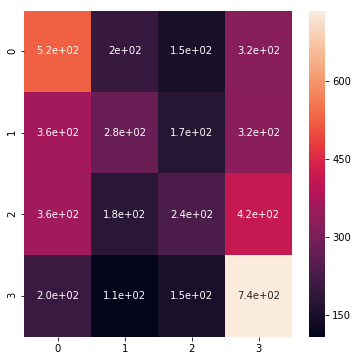

In [35]:
confusion_mc = confusion_matrix(y_ada_validation, prediction_ada_validation)
# print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

## Balanced datasets - SMOTE

In [36]:
smo = SMOTE(kind="svm")
X_resampled, y_resampled = smo.fit_sample(X_scaled, train["Target"])

X_smo_train, X_smo_validation, y_smo_train, y_smo_validation = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)

prediction_smo_train, prediction_smo_validation = logistic_regression_prediction(1e7, X_smo_train, y_smo_train, X_smo_validation)

In [37]:
accuracy, precision, recall, f1 = all_score(y_smo_validation, prediction_smo_validation)
print_score(accuracy, precision, recall, f1)

('Accuracy:', 0.5422138836772983)
('Precision:', 0.5307493814305811)
('Recall:', 0.5421886294134001)
('F1:', 0.5315668747940315)


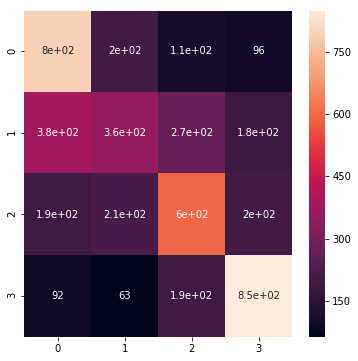

In [38]:
confusion_mc = confusion_matrix(y_smo_validation, prediction_smo_validation)
# print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

In [39]:
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(prediction_smo_validation, y_smo_validation, target_names=target_names))

             precision    recall  f1-score   support

    class 1       0.66      0.54      0.60      1465
    class 2       0.30      0.43      0.35       833
    class 3       0.50      0.51      0.50      1171
    class 4       0.71      0.64      0.67      1328

avg / total       0.57      0.54      0.55      4797



## Hyper-parameters tuning

In [40]:
reg_params = [1e-7, 0.000001, 0.00001, 0.0001, 0.001,0.01,0.1,1,10,100,1000]
accuracy_scores = {"train": [], "validation": []}
precision_scores = {"train": [], "validation": []}
recall_scores = {"train": [], "validation": []}
f1_scores = {"train": [], "validation": []}
print("Number of neighbor: "),
for reg_param in reg_params:
    print(", {0}".format(reg_param)),
    prediction_smo_train, prediction_smo_validation = logistic_regression_prediction(reg_param, X_smo_train, y_smo_train, X_smo_validation)
    accuracy, precision, recall, f1 = all_score(y_smo_train, prediction_smo_train)
    accuracy_scores["train"].append(accuracy)
    precision_scores["train"].append(precision)
    recall_scores["train"].append(recall)
    f1_scores["train"].append(f1)  
    
    accuracy, precision, recall, f1 = all_score(y_smo_validation, prediction_smo_validation)
    accuracy_scores["validation"].append(accuracy)
    precision_scores["validation"].append(precision)
    recall_scores["validation"].append(recall)    
    f1_scores["validation"].append(f1)

Number of neighbor:  , 1e-07 , 1e-06 , 1e-05 , 0.0001 , 0.001 , 0.01 , 0.1 , 1 , 10 , 100 , 1000


In [41]:
regs = [1/reg for reg in reg_params]
regs

[10000000.0,
 1000000.0,
 99999.99999999999,
 10000.0,
 1000.0,
 100.0,
 10.0,
 1.0,
 0.1,
 0.01,
 0.001]

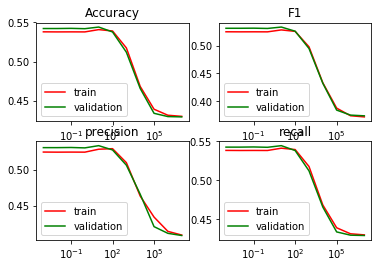

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0][0].semilogx(regs, accuracy_scores["train"], c="r", label="train")
ax[0][0].semilogx(regs, accuracy_scores["validation"], c="g", label="validation")
ax[0][0].set_title("Accuracy")
ax[0][0].legend()

ax[0][1].semilogx(regs, f1_scores["train"], c="r", label="train")
ax[0][1].semilogx(regs, f1_scores["validation"], c="g", label="validation")
ax[0][1].set_title("F1")
ax[0][1].legend()

ax[1][0].semilogx(regs, precision_scores["train"], c="r", label="train")
ax[1][0].semilogx(regs, precision_scores["validation"], c="g", label="validation")
ax[1][0].set_title("precision")
ax[1][0].legend()

ax[1][1].semilogx(regs, recall_scores["train"], c="r", label="train")
ax[1][1].semilogx(regs, recall_scores["validation"], c="g", label="validation")
ax[1][1].set_title("recall")
ax[1][1].legend()

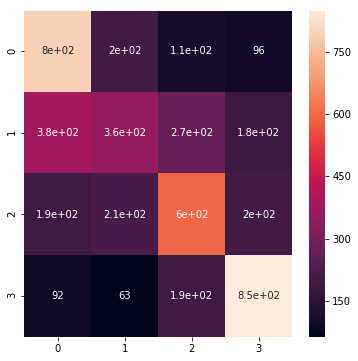

In [43]:
nearest_neighbors = LogisticRegression(C=1000)
model = nearest_neighbors.fit(X_smo_train, y_smo_train)
prediction_smo_validation = model.predict(X_smo_validation)


# print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

In [44]:
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(prediction_smo_validation, y_smo_validation, target_names=target_names))

             precision    recall  f1-score   support

    class 1       0.66      0.54      0.60      1465
    class 2       0.30      0.43      0.35       833
    class 3       0.50      0.51      0.50      1171
    class 4       0.71      0.64      0.67      1328

avg / total       0.57      0.54      0.55      4797



In [46]:
prediction_kaggle = model.predict(x_test_scaled)

In [47]:
unique_elements, counts_elements = np.unique(prediction_kaggle, return_counts=True)
print(unique_elements)
print(counts_elements)

[1 2 3 4]
[ 3722  2581  4711 12842]


In [48]:
id_kaggle = test["Id"]

In [49]:
d = {"Id": id_kaggle, "Target": prediction_kaggle}
data = pd.DataFrame(d)

In [50]:
data.head(5)

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,3


In [53]:
data.to_csv("/home/ubuntu/Documents/costa_rican_household_poverty/submission/sklearn/smote/logisticRegression.csv", index=False)

NameError: name 'data' is not defined